In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import numpy as np
from utils import plot_sparsity_matrix,weight_histograms,set_all_seeds, plot_weight_histograms, make_paths_relative_to_root

import data as module_data
import models as module_arch
import evaluation as module_metric

import quantization as module_quantize
import pruning as module_prune

from parse_config import ConfigParser
from trainer.trainer import Trainer

make_paths_relative_to_root()

# Introduction
This notebook studies the Deep Compression process, described in the paper "Deep Compression: compressing deep neural networks with pruning, trained quantization and Huffman Coding, Song Han et al., 2016." [[1](#1)]
Here we replicate the results of the paper using MNIST dataset, using the LeNet-300-100 and LeNet-5 models [[2](#2)].

# Configuration

In [2]:
# Retrieve a pretrained model
config_dict = {'resume':'runs/models/Mnist_LeNet300/0305_212840/model_best.pth'}

config = ConfigParser.from_dict(config_dict)

data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

dataiter = iter(data_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


Print images from dataset and their labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
4 5 3 3


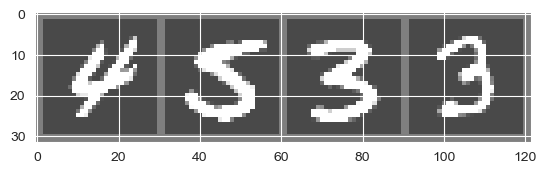

In [3]:
import matplotlib.pyplot as plt
from utils import imshow

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join(f'{labels[j]:1d}' for j in range(4)))

# LeNet-300-100

LeNet-300-100 is a Fully-Connected neural network, presented in [[2](#2)].
It is composed by two hidden layers, with respectively 300 and 100 units.

Differently from the original implementation, we employ ReLU activation instead of tanh, and we use a softmax over the last layer logits to calculate the predictions and a negative log likelihood loss.

In [4]:
 # build model architecture
model = config.init_obj('arch', module_arch)
print(model)

# get function handles of loss and metrics
criterion = getattr(F, config['loss'])
metrics = [getattr(module_metric, met) for met in config['metrics']]

# load pretrained model
print('Loading checkpoint: {} ...'.format(config.resume))
checkpoint = torch.load(config.resume)
state_dict = checkpoint['state_dict']
print('Accuracy before compression: {:.3f}'.format(checkpoint['monitor_best']))
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

LeNet300(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)
Loading checkpoint: runs\models\Mnist_LeNet300\0305_212840\model_best.pth ...
Accuracy before compression: 0.980


LeNet300(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

The error rate on the validation set is 2%, which is slightly worse than what declared in the paper and in the original article of LeCun et al. , 1998.

## Pruning

We have explored two ways of pruning:
- pruning a certain percentage of weights
- pruning all the weights under a threshold, given by the standard deviation of weight magnitude, multiplied by a quality constant $s$

$$ \text{threshold} = \sigma * s $$

In [5]:
pruners = config['pruners']
for pruner in pruners:
    # get type of pruning to use
    prune_fn = getattr(module_prune, pruner['type'])
    iterations = 1 if not 'iterations' in pruner else pruner['iterations']
    for it in range(iterations):
        # prune model
        model = module_prune.prune_model(model, prune_fn, pruner['levels'], None)

        # build optimizer, learning rate scheduler
        trainable_params = filter(lambda p: p.requires_grad, model.parameters())
        optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
        lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

        # avoid model reinitialization inside trainer
        config.resume = None

        trainer = Trainer(model, criterion, metrics, optimizer,
                          config=config,
                          device=device,
                          data_loader=data_loader,
                          valid_data_loader=valid_data_loader,
                          lr_scheduler=lr_scheduler)

        _, acc1, acc5 = trainer._valid_epoch(-1).values()
        #print("Pruning iteration - acc@1:{:.3f} | acc@5:{:.3f}".format(acc1, acc5))

        if pruner['finetune_weights']:
            trainer.train()

        _, acc1, acc5 = trainer._valid_epoch(-1).values()

        print("Pruning iteration {:d} | acc@1:{:.3f} | acc@5:{:.3f}".format(it, acc1, acc5))

Train Epoch: 1 [0/54000 (0%)] Loss: 0.589433
Train Epoch: 1 [1408/54000 (3%)] Loss: 0.290583
Train Epoch: 1 [2816/54000 (5%)] Loss: 0.215940
Train Epoch: 1 [4224/54000 (8%)] Loss: 0.230722
Train Epoch: 1 [5632/54000 (10%)] Loss: 0.190418
Train Epoch: 1 [7040/54000 (13%)] Loss: 0.160539
Train Epoch: 1 [8448/54000 (16%)] Loss: 0.115395
Train Epoch: 1 [9856/54000 (18%)] Loss: 0.093328
Train Epoch: 1 [11264/54000 (21%)] Loss: 0.144284
Train Epoch: 1 [12672/54000 (23%)] Loss: 0.111803
Train Epoch: 1 [14080/54000 (26%)] Loss: 0.090412
Train Epoch: 1 [15488/54000 (29%)] Loss: 0.074714
Train Epoch: 1 [16896/54000 (31%)] Loss: 0.088962
Train Epoch: 1 [18304/54000 (34%)] Loss: 0.132020
Train Epoch: 1 [19712/54000 (37%)] Loss: 0.079439
Train Epoch: 1 [21120/54000 (39%)] Loss: 0.073941
Train Epoch: 1 [22528/54000 (42%)] Loss: 0.155042
Train Epoch: 1 [23936/54000 (44%)] Loss: 0.074350
Train Epoch: 1 [25344/54000 (47%)] Loss: 0.084542
Train Epoch: 1 [26752/54000 (50%)] Loss: 0.075414
Train Epoch: 1 

We can see that validation accuracy drops after pruning, but once the model is finetuned, we reach a slightly better accuracy than the unpruned model. This was also noted in the Deep Compression paper

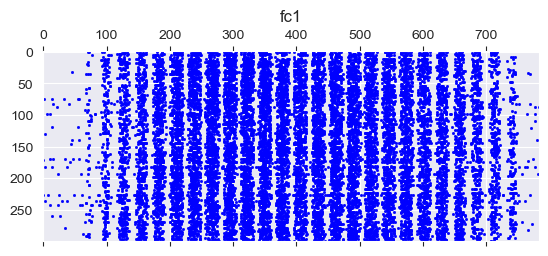

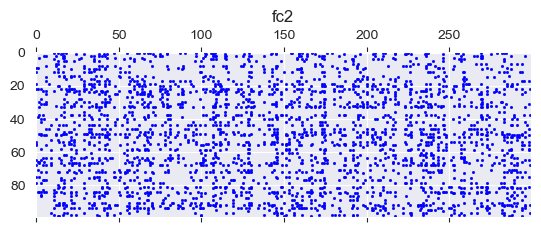

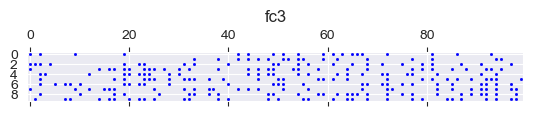

In [6]:
plot_sparsity_matrix(model)

We can see that the fc1 layer is divided in 28 vertical bands, whose width is 28, corresponding to the $28 \times 28$ input pixel.
As stated in [[2](#2)], network pruning detects visual attention regions: the colored regions, correspond to non-zero parameters, are more dense in the center of the image, since the digits are written in the center.

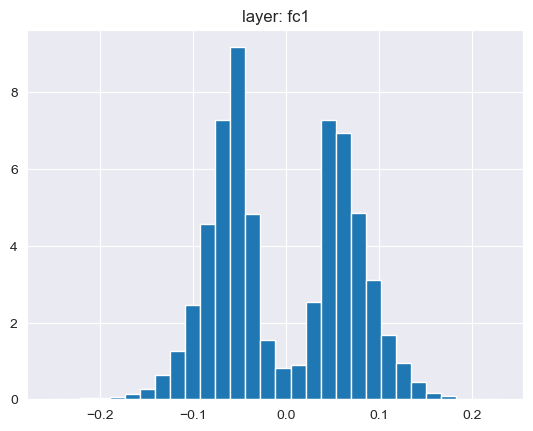

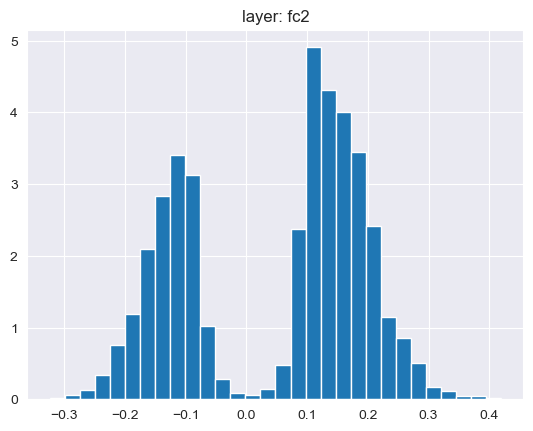

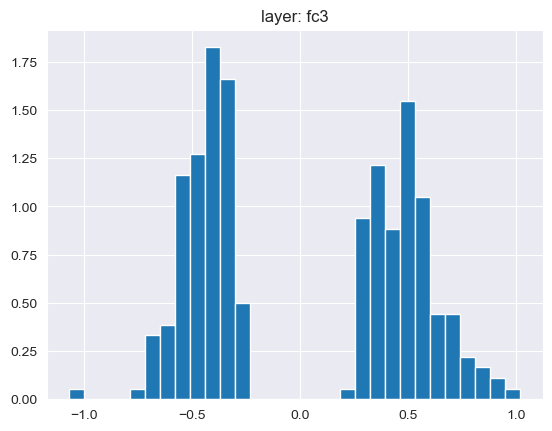

In [7]:
plot_weight_histograms(model)

Pruned weights follow a bimodal distribution

## Quantization

There are two ways of doing quantization:

- Reducing the number of bits used to represent each weight
- Create a codebook of weight values using a clustering algorithm, so that each weight that falls into the cluster will have the same shared weight.

We have implemented the latter using three different quantization methods, which can be found inside `quantization.py`.
All the methods extend a common class `BaseQuantizationMethod` and differ by the way the centroids are computed.

Let's show how the centroids are calculated for the weights of `fc1` layer, for simplicity let's assume to quantize the layer weights in only 3 bits (using 8 weights)

In [8]:
# Number of centroids = 2 ** #bits used to index
pts = 2 ** 3
mat = model.fc1.weight.detach().cpu().view(-1)
# ignore zeros from masked neurons
mat = mat[mat!=0]

### Random (Forgy) Initialization

Randomly chooses `pts` observations from the data set and uses these as the initial centroids. Since the pruned weights form a bimodal distribution, the centroids tend to concentrate around the two peaks.

In [9]:
space_f = np.random.choice(mat, size=pts, replace=False)

### Density-based Initialization

Linearly spaces the CDF in the y-axis, then finds the horizontal intersection with the CDF, and the vertical intersection on the x-axis, which becomes a centroid. Weights are concentrated around the two peaks, but more scattered than the Forgy method.

In [10]:
x, cdf_counts = np.unique(mat, return_counts=True)
y = np.cumsum(cdf_counts) / np.sum(cdf_counts)

eps = 1e-2

space_y = np.linspace(y.min() + eps, y.max() - eps, pts)

idxs = []
# TODO find numpy operator to eliminate for
for i in space_y:
    idx = np.argwhere(np.diff(np.sign(y - i)))[0]
    idxs.append(idx)

idxs = np.stack(idxs)
space_d = x[idxs]

### Linear Initialization
Linearly spaces the centroids between the [min, max] of the original weights. This initialization method is invariant to the distribution of the weights and more scattered compared with the other two methods.

In [11]:
min_ = mat.min()
max_ = mat.max()
space_l = np.linspace(min_, max_, num=pts)

We can visualize the centroids computed by these three methods and see how they are distributed with respect to the model PDF and CDF

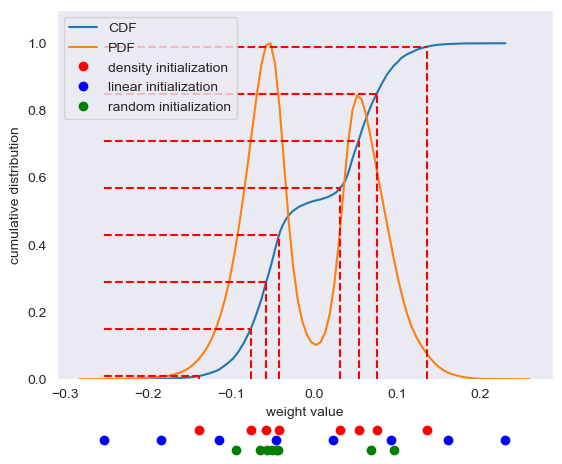

In [12]:
import seaborn as sns
import pylab as P
import scipy.stats as stats

# credits https://stackoverflow.com/questions/55128462/how-to-normalize-seaborn-distplot
def seaborn_kde_support(data, bw, gridsize, cut, clip):
        if clip is None:
            clip = (-np.inf, np.inf)
        support_min = max(data.min() - bw * cut, clip[0])
        support_max = min(data.max() + bw * cut, clip[1])
        return np.linspace(support_min, support_max, gridsize)

def normalize(x):
        return (x - x.min(0)) / x.ptp(0)

kde_estim = stats.gaussian_kde(x, bw_method='scott')

# manual linearization of data
#linearized = np.linspace(quotient.min(), quotient.max(), num=500)

# or better: mimic seaborn's internal stuff
bw = kde_estim.scotts_factor() * np.std(x)
linearized = seaborn_kde_support(x, bw, 100, 3, None)

Z = kde_estim.evaluate(linearized)
Z2 = normalize(Z)

fig, ax = plt.subplots()
ax.plot(x, y, label= 'CDF')
ax.plot(linearized,Z2, label='PDF')

ax.set_ylabel('cumulative distribution')
ax.set_xlabel('weight value')
ax.set_ylim(0,1.1)

ax.plot(space_d,np.zeros_like(space_d) -0.15,'ro',clip_on=False,label='density initialization')
ax.plot(space_l,np.zeros_like(space_d) -0.18 ,'bo',clip_on=False,label='linear initialization')
ax.plot(space_f,np.zeros_like(space_d) -0.21,'go',clip_on=False,label='random initialization')

for idx in idxs:
    ax.hlines(y[idx], x.min(), x[idx], linestyles='--',colors='r')
    ax.vlines(x[idx], y.min(), y[idx], linestyles='--',colors='r')

ax.grid(False)
_ = ax.legend()

Finally, let's compare performances of the three methods:

In [13]:
quantizer = config['quantizer']
quantize_fn = getattr(module_quantize, quantizer['type'])

model = module_quantize.quantize_model(model, quantize_fn, quantizer['levels'], None)

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

trainer = Trainer(model, criterion, metrics, optimizer,
                  config=config,
                  device=device,
                  data_loader=data_loader,
                  valid_data_loader=valid_data_loader,
                  lr_scheduler=lr_scheduler)

_, acc1, acc5 = trainer._valid_epoch(-1).values()
print("Tested model after quantization - acc@1:{:.3f} | acc@5:{:.3f}".format(acc1, acc5))

if quantizer['finetune_weights']:
    trainer.train()

_, acc1, acc5 = trainer._valid_epoch(-1).values()
print("Tested model after finetuning - acc@1:{:.3f} | acc@5:{:.3f}".format(acc1, acc5))

Tested model after quantization - acc@1:0.987 | acc@5:1.000
Train Epoch: 1 [0/54000 (0%)] Loss: 0.009185
Train Epoch: 1 [1408/54000 (3%)] Loss: 0.024128
Train Epoch: 1 [2816/54000 (5%)] Loss: 0.009847
Train Epoch: 1 [4224/54000 (8%)] Loss: 0.032538
Train Epoch: 1 [5632/54000 (10%)] Loss: 0.030814
Train Epoch: 1 [7040/54000 (13%)] Loss: 0.002843
Train Epoch: 1 [8448/54000 (16%)] Loss: 0.007042
Train Epoch: 1 [9856/54000 (18%)] Loss: 0.017232
Train Epoch: 1 [11264/54000 (21%)] Loss: 0.008078
Train Epoch: 1 [12672/54000 (23%)] Loss: 0.006913
Train Epoch: 1 [14080/54000 (26%)] Loss: 0.009492
Train Epoch: 1 [15488/54000 (29%)] Loss: 0.015784
Train Epoch: 1 [16896/54000 (31%)] Loss: 0.007922
Train Epoch: 1 [18304/54000 (34%)] Loss: 0.004232
Train Epoch: 1 [19712/54000 (37%)] Loss: 0.001856
Train Epoch: 1 [21120/54000 (39%)] Loss: 0.007594
Train Epoch: 1 [22528/54000 (42%)] Loss: 0.003007
Train Epoch: 1 [23936/54000 (44%)] Loss: 0.002648
Train Epoch: 1 [25344/54000 (47%)] Loss: 0.007029
Train

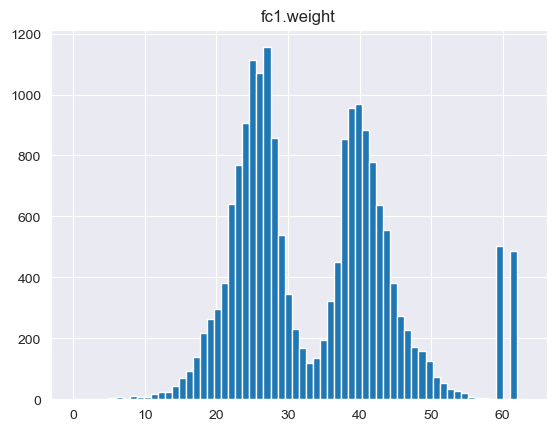

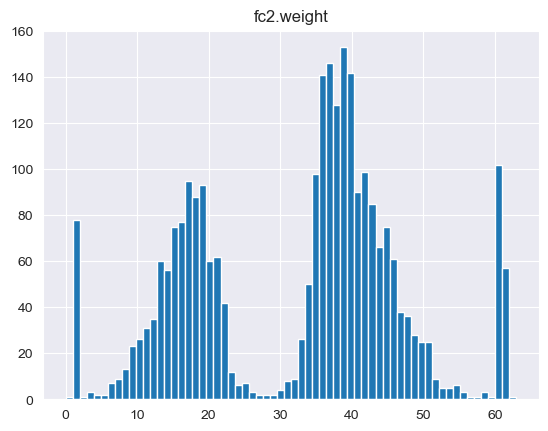

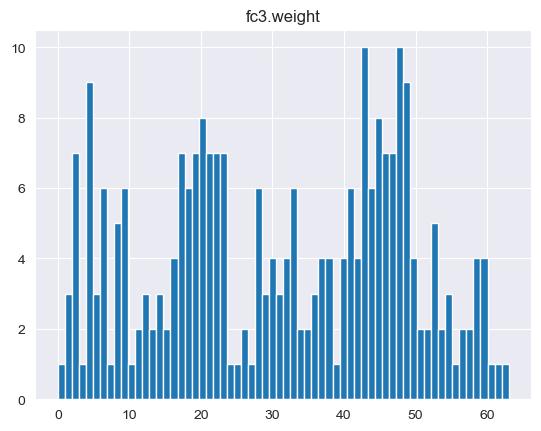

In [14]:
import numpy as np
for param_name, bits in quantizer['levels'].items():
    t = model.state_dict()[param_name + '_indices'].detach().cpu()
    plt.hist(t.numpy(),bins=2**bits)
    plt.title(param_name)
    plt.show()

## Huffman encoding

# LeNet-5

![Lenet5](./../assets/lenet-5_1.jpg "LeNet 5")

The input is a $32 \times 32$ image, since [[2](#2)] found desirable to have distinctive features of each character in the center of the receptive field of the highest-level feature detectors.

- C1 is a convolutional layer with 6 feature maps and a kernel of $5 \times 5$.
- S

Images need to be rescaled to size 32x32 as described in LeCun et al. 1998

## Learning connections

## Pruning

## Quantization

# References
<a id="1">[1]</a> Han, Song, Huizi Mao, and William J. Dally. "Deep compression: Compressing deep neural networks with pruning, trained quantization and huffman coding." arXiv preprint arXiv:1510.00149 (2015).
<a id="1">[2]</a> LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.
<a id="2">[3]</a> Han, Song, et al. "Learning both weights and connections for efficient neural network." Advances in neural information processing systems 28 (2015).